In [1]:
!pip install wordcloud

In [2]:
!pip install textblob

In [3]:
!pip install gensim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.22.4 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.



  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3


In [4]:
pip install numpy tensorflow


  Using cached numpy-1.26.3-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.3 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.26.3 which is incompatible.


In [5]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

import joblib
from tqdm import tqdm
import contractions



C:\Users\Dell\OneDrive\Documents\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
data = pd.read_csv("Text_Dataset.csv").drop(columns=['id', 'index', "Annotation"])
data.columns = ['text', 'label']


In [10]:
data.head()

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0


In [11]:
data['text'].sample(10).values[0]

"RT @octal: Wow. This really isn't how to do customer support. https://t.co/fHLfHyunuu"

In [12]:
data['text'][0]

'@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj'

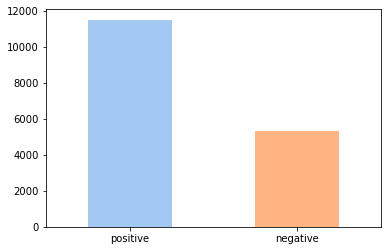

In [13]:
data['label'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['positive', 'negative'], rotation=0);

In [14]:
import nltk
nltk.download('words')
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [15]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(str(x)))
data

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


In [16]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
data['correct_text'] = 'text'
data

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,text
4,#mkr No No No No No No,0.0,mkr no no no no no no,text
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,text


In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('wordnet')
count = 0
for text in tqdm(data['cleaned_text']):
    data['correct_text'][count] = correct_text(text, lemma=True)
    count +=1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  0%|                                                                                        | 0/16851 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Temp/ipykernel_8080/2533298553.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['correct_text'][count] = correct_text(text, lemma=True)
100%|███████████████████████████████████████████████████████████████████████████| 16851/16851 [01:39<00:00, 170.19it/s]


In [19]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces

In [20]:
data

,text,label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,7,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,12,82
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...,10,50
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly,7,47
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,1,3
...,...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,9,42
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,10,50
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,14,93
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17


<AxesSubplot:>

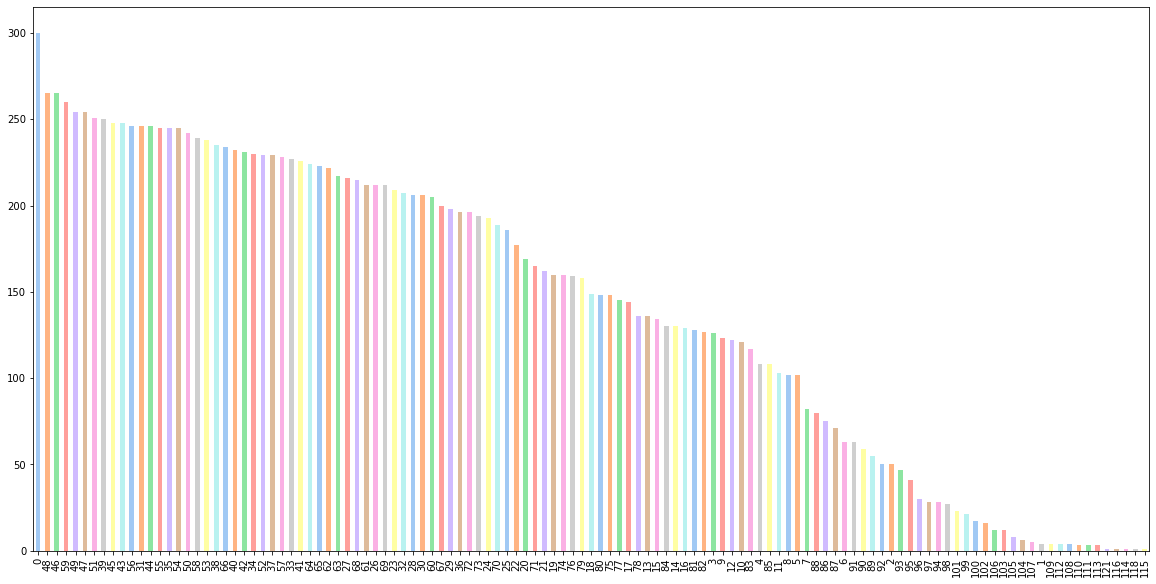

In [21]:
plt.figure(figsize=(20,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [22]:
data = data[~(data['char_count'] == 0)].reset_index(drop=True)

In [23]:
data[(data['label'] == 0)]

,text,label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,7,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,12,82
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,1,3
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,rt saudi preacher who raped and tortured his f...,rt saudi preacher rap torture five year old da...,11,66
7,Going to make some pancakes.....Don't hve any ...,0.0,going to make some pancakes do not hve any str...,go make pancake hve strawberry hve banana mkr,8,45
...,...,...,...,...,...,...
16546,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,9,42
16547,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,10,50
16548,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,14,93
16549,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17


In [24]:
final_data = data.drop(columns=['text', 'cleaned_text', 'word_count', 'char_count'])
# final_data.to_csv("final_cleaned_data.csv", index=False)

In [25]:
# final_data = pd.read_csv('final_cleaned_data.csv')
final_data

,label,correct_text
0,0.0,read context change meaning history islamic sl...
1,0.0,idiot claim people try stop become terrorist m...
2,1.0,rt call sexist go auto place would rather talk...
3,1.0,wrong isi follow example mohammed quran exactly
4,0.0,mkr
...,...,...
16546,0.0,feel sorry girl safe kat andre go home mkr
16547,0.0,mkr pretty good dish happy ok well never eat p...
16548,0.0,rt deconstruct lemon tart please go one season...
16549,0.0,stupid talk block


In [26]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()


In [27]:
vocab = Counter()
for text in final_data['correct_text']:
    build_vocab(vocab, text)

In [29]:
save__vocab_list(vocab, 'vocab.txt')

In [30]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

#  define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


In [31]:
X = final_data['correct_text']
y = final_data['label']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [33]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [34]:
vocab_set = set([x for x in vocab if len(x)>2])

tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [35]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten
from keras.models import Sequential
from keras.layers import Embedding, Flatten


clf_model = define_model(vocab_size, max_length, x_train.shape[1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1047500   
                                                                 
 flatten (Flatten)           (None, 2300)              0         
                                                                 
 dense (Dense)               (None, 45)                103545    
                                                                 
 dense_1 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1151091 (4.39 MB)
Trainable params: 1151091 (4.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
clf_model.fit(x_train, y_train.values, epochs=10, verbose=2, batch_size=74)

Epoch 1/10


150/150 - 7s - loss: 0.6229 - accuracy: 0.6737 - 7s/epoch - 44ms/step
Epoch 2/10
150/150 - 2s - loss: 0.5841 - accuracy: 0.6935 - 2s/epoch - 14ms/step
Epoch 3/10
150/150 - 2s - loss: 0.5203 - accuracy: 0.7668 - 2s/epoch - 13ms/step
Epoch 4/10
150/150 - 2s - loss: 0.4355 - accuracy: 0.8232 - 2s/epoch - 12ms/step
Epoch 5/10
150/150 - 2s - loss: 0.3679 - accuracy: 0.8493 - 2s/epoch - 12ms/step
Epoch 6/10
150/150 - 2s - loss: 0.3178 - accuracy: 0.8763 - 2s/epoch - 12ms/step
Epoch 7/10
150/150 - 2s - loss: 0.2776 - accuracy: 0.8950 - 2s/epoch - 12ms/step
Epoch 8/10
150/150 - 2s - loss: 0.2436 - accuracy: 0.9101 - 2s/epoch - 12ms/step
Epoch 9/10
150/150 - 2s - loss: 0.2138 - accuracy: 0.9242 - 2s/epoch - 14ms/step
Epoch 10/10
150/150 - 2s - loss: 0.1874 - accuracy: 0.9362 - 2s/epoch - 12ms/step


In [38]:
clf_model.evaluate(x_train, y_train, verbose=0)[1]

0.9461628794670105

In [39]:
clf_model.evaluate(x_test, y_test, verbose=0)[1]

0.8222262859344482

In [40]:
clf_model.predict(x_test[0].reshape(1,-1))[0,0]

1/1 [==============================] - 0s 141ms/step


0.72350794

In [41]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=clf_model):
    line = text
    # clean review
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
#     print(yhat)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'


In [42]:
predict_sentiment(final_data['correct_text'][200], vocab_set, tokenizer, max_length, clf_model)

(0.967494647949934, 'NEGATIVE')

In [43]:
clf_model.save('cyber_det.h5')

C:\Users\Dell\OneDrive\Documents\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
